Student Feedback Analysis By Using Deep Learning Project

In [73]:
import zipfile
import os

zip_file_path = '/content/archive (30).zip'
extraction_path = './extracted_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to: {extraction_path}")

# List the extracted files to identify the CSV
extracted_files = os.listdir(extraction_path)
print("Extracted files:", extracted_files)

Files extracted to: ./extracted_data
Extracted files: ['finalDataset0.2.xlsx']


In [74]:
import pandas as pd

file_path = os.path.join(extraction_path, 'finalDataset0.2.xlsx')

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

print("DataFrame loaded successfully. Displaying the first 5 rows:")
print(df.head())

print("\nColumn names in the DataFrame:")
print(df.columns)

DataFrame loaded successfully. Displaying the first 5 rows:
   teaching                                         teaching.1  coursecontent  \
0         0  teacher are punctual but they should also give...            0.0   
1         1                                              Good            -1.0   
2         1  Excellent lectures are delivered by teachers a...            1.0   
3         1                                               Good           -1.0   
4         1  teachers give us all the information required ...            1.0   

                                     coursecontent.1  examination  \
0                     content of courses are average          1.0   
1                                           Not good          1.0   
2  All courses material provide very good knowled...          1.0   
3  Content of course is perfectly in line with th...         -1.0   
4           content of courses improves my knowledge          1.0   

                                      

In [76]:
import pandas as pd

# Define the column pairs as identified from the previous df.columns output and instructions
column_pairs = [
    ('teaching', 'teaching.1'),
    ('coursecontent', 'coursecontent.1'),
    ('examination', 'Examination'), # 'examination' is sentiment, 'Examination' is text
    ('labwork', 'labwork.1'),
    ('library_facilities', ' library_facilities'), # Note the space in ' library_facilities' for text
    ('extracurricular', 'extracurricular.1')
]

# List to hold all consolidated text-sentiment entries
consolidated_data = []

# Iterate through each column pair and extract data
for sentiment_col, text_col in column_pairs:
    for index, row in df.iterrows():
        text_entry = row[text_col]
        sentiment_score = row[sentiment_col]

        # Only add if both text and sentiment are not NaN
        if pd.notna(text_entry) and pd.notna(sentiment_score):
            consolidated_data.append({
                'text': text_entry,
                'sentiment_score': sentiment_score
            })

# Create the new consolidated DataFrame
consolidated_df = pd.DataFrame(consolidated_data)

# Remove any remaining rows where 'text' or 'sentiment_score' might be missing after initial filtering
consolidated_df.dropna(subset=['text', 'sentiment_score'], inplace=True)

print("Consolidated DataFrame created. Displaying the first 5 rows:")
print(consolidated_df.head())
print(f"\nTotal entries in consolidated DataFrame: {len(consolidated_df)}")

Consolidated DataFrame created. Displaying the first 5 rows:
                                                text  sentiment_score
0  teacher are punctual but they should also give...              0.0
1                                              Good               1.0
2  Excellent lectures are delivered by teachers a...              1.0
3                                               Good              1.0
4  teachers give us all the information required ...              1.0

Total entries in consolidated DataFrame: 1105


In [77]:
sentiment_mapping = {
    -1.0: 'negative',
    0.0: 'neutral',
    1.0: 'positive'
}

consolidated_df['sentiment_label'] = consolidated_df['sentiment_score'].map(sentiment_mapping)

print("Sentiment scores mapped to labels. Displaying the first 5 rows with new 'sentiment_label' column:")
print(consolidated_df.head())
print(f"\nValue counts for 'sentiment_label':\n{consolidated_df['sentiment_label'].value_counts()}")

Sentiment scores mapped to labels. Displaying the first 5 rows with new 'sentiment_label' column:
                                                text  sentiment_score  \
0  teacher are punctual but they should also give...              0.0   
1                                              Good               1.0   
2  Excellent lectures are delivered by teachers a...              1.0   
3                                               Good              1.0   
4  teachers give us all the information required ...              1.0   

  sentiment_label  
0         neutral  
1        positive  
2        positive  
3        positive  
4        positive  

Value counts for 'sentiment_label':
sentiment_label
positive    808
neutral     150
negative    147
Name: count, dtype: int64


In [78]:
import numpy as np

# Ensure all entries in the 'text' column are string type
consolidated_df['text'] = consolidated_df['text'].astype(str)

# Remove rows where 'text' column is empty or contains only whitespace
# Also consider any 'nan' string representations that might appear after astype(str)
consolidated_df = consolidated_df[consolidated_df['text'].str.strip() != ''].copy()
consolidated_df = consolidated_df[consolidated_df['text'].str.lower() != 'nan'].copy()

print("Initial cleaning of 'text' column complete. Displaying the first 5 rows:")
print(consolidated_df.head())
print(f"\nTotal entries in consolidated DataFrame after initial cleaning: {len(consolidated_df)}")

Initial cleaning of 'text' column complete. Displaying the first 5 rows:
                                                text  sentiment_score  \
0  teacher are punctual but they should also give...              0.0   
1                                              Good               1.0   
2  Excellent lectures are delivered by teachers a...              1.0   
3                                               Good              1.0   
4  teachers give us all the information required ...              1.0   

  sentiment_label  
0         neutral  
1        positive  
2        positive  
3        positive  
4        positive  

Total entries in consolidated DataFrame after initial cleaning: 1105


In [79]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

print("NLTK libraries imported and data downloaded successfully.")

NLTK libraries imported and data downloaded successfully.


In [80]:
import string # Already imported nltk, stopwords, word_tokenize, pos_tag in previous step

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing, remove punctuation, and remove stop words
    processed_tokens = []
    for word in tokens:
        word = word.lower() # Lowercasing
        # Remove punctuation by checking if word is alphanumeric or just contains a single punctuation mark
        # A more robust way: filter out words that are purely punctuation
        if word not in string.punctuation and word.isalpha(): # Check if it's an alphabetic word and not punctuation
            if word not in stop_words: # Stop word removal
                processed_tokens.append(word)

    # POS tagging for the remaining words
    pos_tagged_tokens = pos_tag(processed_tokens)

    return pos_tagged_tokens

print("Text preprocessing function 'preprocess_text' defined successfully.")


Text preprocessing function 'preprocess_text' defined successfully.


In [81]:
consolidated_df['processed_text'] = consolidated_df['text'].apply(preprocess_text)

print("Preprocessing applied. Displaying the first 5 rows with 'processed_text' column:")
print(consolidated_df[['text', 'sentiment_score', 'sentiment_label', 'processed_text']].head())
print(f"\nValue counts for 'sentiment_label':\n{consolidated_df['sentiment_label'].value_counts()}")

Preprocessing applied. Displaying the first 5 rows with 'processed_text' column:
                                                text  sentiment_score  \
0  teacher are punctual but they should also give...              0.0   
1                                              Good               1.0   
2  Excellent lectures are delivered by teachers a...              1.0   
3                                               Good              1.0   
4  teachers give us all the information required ...              1.0   

  sentiment_label                                     processed_text  
0         neutral  [(teacher, RB), (punctual, JJ), (also, RB), (g...  
1        positive                                       [(good, JJ)]  
2        positive  [(excellent, JJ), (lectures, NNS), (delivered,...  
3        positive                                       [(good, JJ)]  
4        positive  [(teachers, NNS), (give, VBP), (us, PRP), (inf...  

Value counts for 'sentiment_label':
sentiment_label
p

In [82]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('tokenizers/punkt_tab') # Add download for punkt_tab
except LookupError:
    nltk.download('punkt_tab')

print("NLTK libraries imported and data downloaded successfully.")

NLTK libraries imported and data downloaded successfully.


In [83]:
consolidated_df['processed_text'] = consolidated_df['text'].apply(preprocess_text)

print("Preprocessing applied. Displaying the first 5 rows with 'processed_text' column:")
print(consolidated_df[['text', 'sentiment_score', 'sentiment_label', 'processed_text']].head())
print(f"\nValue counts for 'sentiment_label':\n{consolidated_df['sentiment_label'].value_counts()}")

Preprocessing applied. Displaying the first 5 rows with 'processed_text' column:
                                                text  sentiment_score  \
0  teacher are punctual but they should also give...              0.0   
1                                              Good               1.0   
2  Excellent lectures are delivered by teachers a...              1.0   
3                                               Good              1.0   
4  teachers give us all the information required ...              1.0   

  sentiment_label                                     processed_text  
0         neutral  [(teacher, RB), (punctual, JJ), (also, RB), (g...  
1        positive                                       [(good, JJ)]  
2        positive  [(excellent, JJ), (lectures, NNS), (delivered,...  
3        positive                                       [(good, JJ)]  
4        positive  [(teachers, NNS), (give, VBP), (us, PRP), (inf...  

Value counts for 'sentiment_label':
sentiment_label
p

In [84]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('tokenizers/punkt_tab') # Add download for punkt_tab
except LookupError:
    nltk.download('punkt_tab')

print("NLTK libraries imported and data downloaded successfully.")

NLTK libraries imported and data downloaded successfully.


In [85]:
consolidated_df['processed_text'] = consolidated_df['text'].apply(preprocess_text)

print("Preprocessing applied. Displaying the first 5 rows with 'processed_text' column:")
print(consolidated_df[['text', 'sentiment_score', 'sentiment_label', 'processed_text']].head())
print(f"\nValue counts for 'sentiment_label':\n{consolidated_df['sentiment_label'].value_counts()}")

Preprocessing applied. Displaying the first 5 rows with 'processed_text' column:
                                                text  sentiment_score  \
0  teacher are punctual but they should also give...              0.0   
1                                              Good               1.0   
2  Excellent lectures are delivered by teachers a...              1.0   
3                                               Good              1.0   
4  teachers give us all the information required ...              1.0   

  sentiment_label                                     processed_text  
0         neutral  [(teacher, RB), (punctual, JJ), (also, RB), (g...  
1        positive                                       [(good, JJ)]  
2        positive  [(excellent, JJ), (lectures, NNS), (delivered,...  
3        positive                                       [(good, JJ)]  
4        positive  [(teachers, NNS), (give, VBP), (us, PRP), (inf...  

Value counts for 'sentiment_label':
sentiment_label
p

In [86]:
sentences = []
for processed_entry in consolidated_df['processed_text']:
    words = [word for word, pos_tag in processed_entry]
    if words: # Only add if there are actual words after processing
        sentences.append(words)

print(f"Number of sentences (documents) for Word2Vec training: {len(sentences)}")
print("First 5 extracted sentences:")
for i, sent in enumerate(sentences[:5]):
    print(f"Sentence {i+1}: {sent}")

Number of sentences (documents) for Word2Vec training: 1105
First 5 extracted sentences:
Sentence 1: ['teacher', 'punctual', 'also', 'give', 'us', 'practical', 'knowledge', 'theortical']
Sentence 2: ['good']
Sentence 3: ['excellent', 'lectures', 'delivered', 'teachers', 'teachers', 'punctual']
Sentence 4: ['good']
Sentence 5: ['teachers', 'give', 'us', 'information', 'required', 'improve', 'performance']


In [87]:
from gensim.models import Word2Vec
import os

# Initialize Word2Vec model
# vector_size: Dimensionality of the word embeddings
# window: Maximum distance between the current and predicted word within a sentence
# min_count: Ignores all words with total frequency lower than this
# sg: Training algorithm; 1 for skip-gram, 0 for CBOW
# workers: Number of CPU cores to use for training

model = Word2Vec(
    sentences=sentences, # Corpus prepared in the previous step
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    workers=os.cpu_count() # Use all available CPU cores
)

# Train the Word2Vec model
# total_examples: Count of the sentences in the corpus
# epochs: Number of iterations (epochs) over the corpus
model.train(sentences, total_examples=len(sentences), epochs=10)

print("Word2Vec model trained successfully.")

# Print the total vocabulary size
vocabulary_size = len(model.wv)
print(f"Total vocabulary size: {vocabulary_size}")

# Verify embeddings for a common word (e.g., 'good')
# Check if 'good' is in the vocabulary before trying to access its vector
if 'good' in model.wv:
    good_vector = model.wv['good']
    print(f"Embedding for 'good': {good_vector[:10]}...") # Print first 10 dimensions for brevity
else:
    print("'good' not found in vocabulary. Please choose another common word for verification.")

Word2Vec model trained successfully.
Total vocabulary size: 985
Embedding for 'good': [ 0.07476832  0.19148488  0.07179133 -0.11507433  0.03987416 -0.18716194
  0.09028018  0.3743426  -0.03959643 -0.10640352]...


In [88]:
!pip install gensim
from gensim.models import Word2Vec
import os

# Initialize Word2Vec model
# vector_size: Dimensionality of the word embeddings
# window: Maximum distance between the current and predicted word within a sentence
# min_count: Ignores all words with total frequency lower than this
# sg: Training algorithm; 1 for skip-gram, 0 for CBOW
# workers: Number of CPU cores to use for training

model = Word2Vec(
    sentences=sentences, # Corpus prepared in the previous step
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    workers=os.cpu_count() # Use all available CPU cores
)

# Train the Word2Vec model
# total_examples: Count of the sentences in the corpus
# epochs: Number of iterations (epochs) over the corpus
model.train(sentences, total_examples=len(sentences), epochs=10)

print("Word2Vec model trained successfully.")

# Print the total vocabulary size
vocabulary_size = len(model.wv)
print(f"Total vocabulary size: {vocabulary_size}")

# Verify embeddings for a common word (e.g., 'good')
# Check if 'good' is in the vocabulary before trying to access its vector
if 'good' in model.wv:
    good_vector = model.wv['good']
    print(f"Embedding for 'good': {good_vector[:10]}...") # Print first 10 dimensions for brevity
else:
    print("'good' not found in vocabulary. Please choose another common word for verification.")

Word2Vec model trained successfully.
Total vocabulary size: 985
Embedding for 'good': [ 0.07476832  0.19148488  0.07179133 -0.11507433  0.03987416 -0.18716194
  0.09028018  0.3743426  -0.03959643 -0.10640352]...


In [89]:
import numpy as np

# Create a vocabulary and word-to-index mapping
word_to_index = {"<PAD>": 0, "<UNK>": 1} # Initialize with padding and unknown tokens
index_to_word = {0: "<PAD>", 1: "<UNK>"}

vocabulary_size = 2 # Start from 2 as 0 and 1 are already taken

for sentence in sentences:
    for word in sentence:
        if word not in word_to_index:
            word_to_index[word] = vocabulary_size
            index_to_word[vocabulary_size] = word
            vocabulary_size += 1

print(f"Created vocabulary of size: {len(word_to_index)}")

# Create the embedding matrix
embedding_dim = model.vector_size
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

# Populate the embedding matrix
for word, i in word_to_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]
    else:
        # For words not in Word2Vec model (e.g., <PAD>, <UNK>), assign a random vector
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print("Embedding matrix created successfully.")


Created vocabulary of size: 987
Embedding matrix shape: (987, 100)
Embedding matrix created successfully.


In [90]:
tokenized_text_indices = []

for processed_entry in consolidated_df['processed_text']:
    # Extract words from (word, POS_tag) tuples
    words = [word for word, pos_tag in processed_entry]

    # Map words to their indices using word_to_index, assign <UNK> index if not found
    indices = [word_to_index.get(word, word_to_index['<UNK>']) for word in words]
    tokenized_text_indices.append(indices)

consolidated_df['tokenized_text_indices'] = tokenized_text_indices

print("Converted 'processed_text' to 'tokenized_text_indices'. Displaying first 5 rows:")
print(consolidated_df[['text', 'processed_text', 'tokenized_text_indices']].head())

Converted 'processed_text' to 'tokenized_text_indices'. Displaying first 5 rows:
                                                text  \
0  teacher are punctual but they should also give...   
1                                              Good    
2  Excellent lectures are delivered by teachers a...   
3                                               Good   
4  teachers give us all the information required ...   

                                      processed_text  \
0  [(teacher, RB), (punctual, JJ), (also, RB), (g...   
1                                       [(good, JJ)]   
2  [(excellent, JJ), (lectures, NNS), (delivered,...   
3                                       [(good, JJ)]   
4  [(teachers, NNS), (give, VBP), (us, PRP), (inf...   

       tokenized_text_indices  
0    [2, 3, 4, 5, 6, 7, 8, 9]  
1                        [10]  
2     [11, 12, 13, 14, 14, 3]  
3                        [10]  
4  [14, 5, 6, 15, 16, 17, 18]  


In [91]:
import numpy as np

# Calculate the length of each tokenized sequence
sequence_lengths = [len(seq) for seq in consolidated_df['tokenized_text_indices']]

# Determine max_sequence_length (e.g., 95th percentile or a fixed value)
max_sequence_length = int(np.percentile(sequence_lengths, 95))

print(f"Calculated 95th percentile for sequence lengths: {max_sequence_length}")
print(f"Max sequence length will be set to: {max_sequence_length}")


Calculated 95th percentile for sequence lengths: 12
Max sequence length will be set to: 12


In [92]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to max_sequence_length
X = pad_sequences(consolidated_df['tokenized_text_indices'], maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Shape of X (padded sequences): {X.shape}")
print("First 5 padded sequences:\n", X[:5])

Shape of X (padded sequences): (1105, 12)
First 5 padded sequences:
 [[ 2  3  4  5  6  7  8  9  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0]
 [11 12 13 14 14  3  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0  0  0]
 [14  5  6 15 16 17 18  0  0  0  0  0]]


In [93]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Get the sentiment labels
sentiment_labels = consolidated_df['sentiment_label'].values.reshape(-1, 1)

# 1. Encode categorical labels to numerical labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(sentiment_labels.ravel())

# 2. One-hot encode the numerical labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

print(f"Shape of y (one-hot encoded labels): {y.shape}")
print("First 5 one-hot encoded labels:\n", y[:5])
print("Corresponding sentiment labels for the first 5 entries:")
for i in range(5):
    print(f"Original: {consolidated_df['sentiment_label'].iloc[i]}, Encoded: {y[i]}")

Shape of y (one-hot encoded labels): (1105, 3)
First 5 one-hot encoded labels:
 [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Corresponding sentiment labels for the first 5 entries:
Original: neutral, Encoded: [0. 1. 0.]
Original: positive, Encoded: [0. 0. 1.]
Original: positive, Encoded: [0. 0. 1.]
Original: positive, Encoded: [0. 0. 1.]
Original: positive, Encoded: [0. 0. 1.]


In [94]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (884, 12)
Shape of X_test: (221, 12)
Shape of y_train: (884, 3)
Shape of y_test: (221, 3)


In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Get dimensions from previously prepared data
vocabulary_size_embedding = embedding_matrix.shape[0]
embedding_dim_embedding = embedding_matrix.shape[1]
input_length_embedding = max_sequence_length
num_classes = y_train.shape[1] # Number of sentiment classes (3: negative, neutral, positive)

# Define the model architecture
model = Sequential()

# Embedding layer (initialized with Word2Vec weights)
model.add(Embedding(
    input_dim=vocabulary_size_embedding,
    output_dim=embedding_dim_embedding,
    weights=[embedding_matrix],
    input_length=input_length_embedding,
    trainable=False # Keep embeddings fixed if not enough data, or set to True for fine-tuning
))

# First LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.2))

# Output Dense layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print("LSTM Model Summary:")
model.summary()

print("Model constructed and compiled successfully. Ready for training.")

LSTM Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │        98,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,700 (385.55 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 98,700 (385.55 KB)

Model constructed and compiled successfully. Ready for training.


In [97]:
print("Training the LSTM model...")
history = model.fit(
    X_train,
    y_train,
    epochs=20, # Using 15 epochs as an example, can be adjusted
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Model training complete.")

Training the LSTM model...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7121 - loss: 0.7189 - val_accuracy: 0.7330 - val_loss: 0.6740
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7342 - loss: 0.6783 - val_accuracy: 0.7285 - val_loss: 0.6450
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7315 - loss: 0.6889 - val_accuracy: 0.7466 - val_loss: 0.6463
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7225 - loss: 0.6964 - val_accuracy: 0.7466 - val_loss: 0.6627
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7204 - loss: 0.6908 - val_accuracy: 0.7330 - val_loss: 0.6393
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7351 - loss: 0.6674 - val_accuracy: 0.7421 - val_loss: 0.6368
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7136 - loss: 0.7132 - val_accuracy: 0.7466 - val_loss: 0.6270
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7392 - loss: 0.6685

In [99]:
print("Evaluating the LSTM model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

print("Model evaluation complete.")

Evaluating the LSTM model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6969 - loss: 0.6198
Test Loss: 0.5865
Test Accuracy: 0.7240
Model evaluation complete.


In [100]:
import numpy as np

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

print("Predicted sentiment labels for the test set.")
print(f"Shape of predicted probabilities: {y_pred_proba.shape}")
print(f"First 5 predicted probabilities:\n{y_pred_proba[:5]}")
print(f"First 5 predicted class labels:\n{y_pred[:5]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Predicted sentiment labels for the test set.
Shape of predicted probabilities: (221, 3)
First 5 predicted probabilities:
[[0.03358798 0.00327827 0.96313375]
 [0.04614886 0.00237768 0.9514734 ]
 [0.15148014 0.27722403 0.5712958 ]
 [0.03709279 0.00252229 0.96038485]
 [0.20194846 0.30769563 0.49035585]]
First 5 predicted class labels:
[2 2 2 2 2]


In [102]:
import numpy as np

# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

print("Converted one-hot encoded true labels to class labels.")
print(f"Shape of true class labels: {y_true.shape}")
print(f"First 5 true class labels:\n{y_true[:5]}")

Converted one-hot encoded true labels to class labels.
Shape of true class labels: (221,)
First 5 true class labels:
[2 2 2 2 2]


In [103]:
from sklearn.metrics import classification_report

# Assuming `label_encoder` from previous steps is available to get class names
# If not, we can infer from the value_counts or define manually based on y mapping
class_names = ['negative', 'neutral', 'positive'] # Based on the sentiment_mapping used earlier

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    negative       0.20      0.07      0.10        30
     neutral       0.20      0.04      0.06        26
    positive       0.76      0.95      0.85       165

    accuracy                           0.72       221
   macro avg       0.39      0.35      0.34       221
weighted avg       0.62      0.72      0.65       221



Confusion Matrix:
[[  2   1  27]
 [  3   1  22]
 [  5   3 157]]


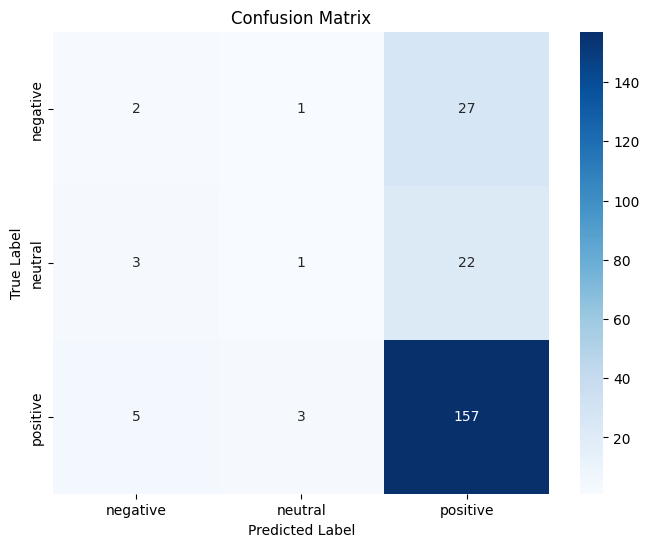

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [107]:
def predict_sentiment_from_text(text):
    # 1. Preprocess the input text using the existing function
    processed_tokens_with_pos = preprocess_text(text)

    # 2. Extract only the words from the (word, POS_tag) tuples
    words = [word for word, pos_tag in processed_tokens_with_pos]

    # 3. Convert words to numerical sequences using word_to_index
    #    Use '<UNK>' for words not found in the vocabulary
    indexed_words = [word_to_index.get(word, word_to_index['<UNK>']) for word in words]

    # 4. Pad the sequence to max_sequence_length
    #    pad_sequences expects a list of sequences, so wrap indexed_words in a list
    padded_sequence = pad_sequences([indexed_words], maxlen=max_sequence_length, padding='post', truncating='post')

    # 5. Get model prediction
    #    model.predict expects a batch of inputs, so use np.array([padded_sequence[0]])
    prediction_probabilities = model.predict(padded_sequence, verbose=0)[0]

    # 6. Determine the predicted class index
    predicted_class_index = np.argmax(prediction_probabilities)

    # 7. Map the index back to the sentiment label
    #    class_names was defined in a previous cell
    predicted_sentiment = class_names[predicted_class_index]

    print(f"Input Text: \"{text}\"")
    print(f"Processed Words: {words}")
    print(f"Indexed Words: {indexed_words}")
    print(f"Padded Sequence: {padded_sequence[0]}")
    print(f"Prediction Probabilities: {prediction_probabilities}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("--------------------------------------------------")

# Test the function with example sentences
example_texts = [
    "The teaching quality is excellent, and I learned a lot.", # Positive
    "The lab facilities are just average, neither good nor bad.", # Neutral
    "The course content was very poor and outdated.", # Negative
    "I absolutely loved the extracurricular activities offered by the university!"
]

for text in example_texts:
    predict_sentiment_from_text(text)


Input Text: "The teaching quality is excellent, and I learned a lot."
Processed Words: ['teaching', 'quality', 'excellent', 'learned', 'lot']
Indexed Words: [22, 87, 11, 1, 674]
Padded Sequence: [ 22  87  11   1 674   0   0   0   0   0   0   0]
Prediction Probabilities: [0.1668596  0.21624605 0.61689436]
Predicted Sentiment: positive
--------------------------------------------------
Input Text: "The lab facilities are just average, neither good nor bad."
Processed Words: ['lab', 'facilities', 'average', 'neither', 'good', 'bad']
Indexed Words: [636, 134, 123, 517, 10, 107]
Padded Sequence: [636 134 123 517  10 107   0   0   0   0   0   0]
Prediction Probabilities: [0.15352061 0.26768363 0.5787958 ]
Predicted Sentiment: positive
--------------------------------------------------
Input Text: "The course content was very poor and outdated."
Processed Words: ['course', 'content', 'poor', 'outdated']
Indexed Words: [300, 296, 94, 1]
Padded Sequence: [300 296  94   1   0   0   0   0   0   0